Check Python version

In [1]:
!python --version

Python 3.9.16


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Local directory
data_dir = "../datasets/climate"
file_name = "temp_anom_w_forcing"
#data_dir = "../datasets/finance"
#file_name = "Returns_short_interest_data_train"
file_path = f"{data_dir}/{file_name}.csv"

# Through online GitHub
# file_path = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv"

In [4]:
dataset = pd.read_csv(file_path)

In [5]:
dataset.shape

(163, 11)

In [6]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [7]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [8]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change 'target' to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

In [12]:
training_points = int(0.8*len(dataset))
train_df = dataset.iloc[:training_points]
test_df = dataset.iloc[training_points:]

Plot graph

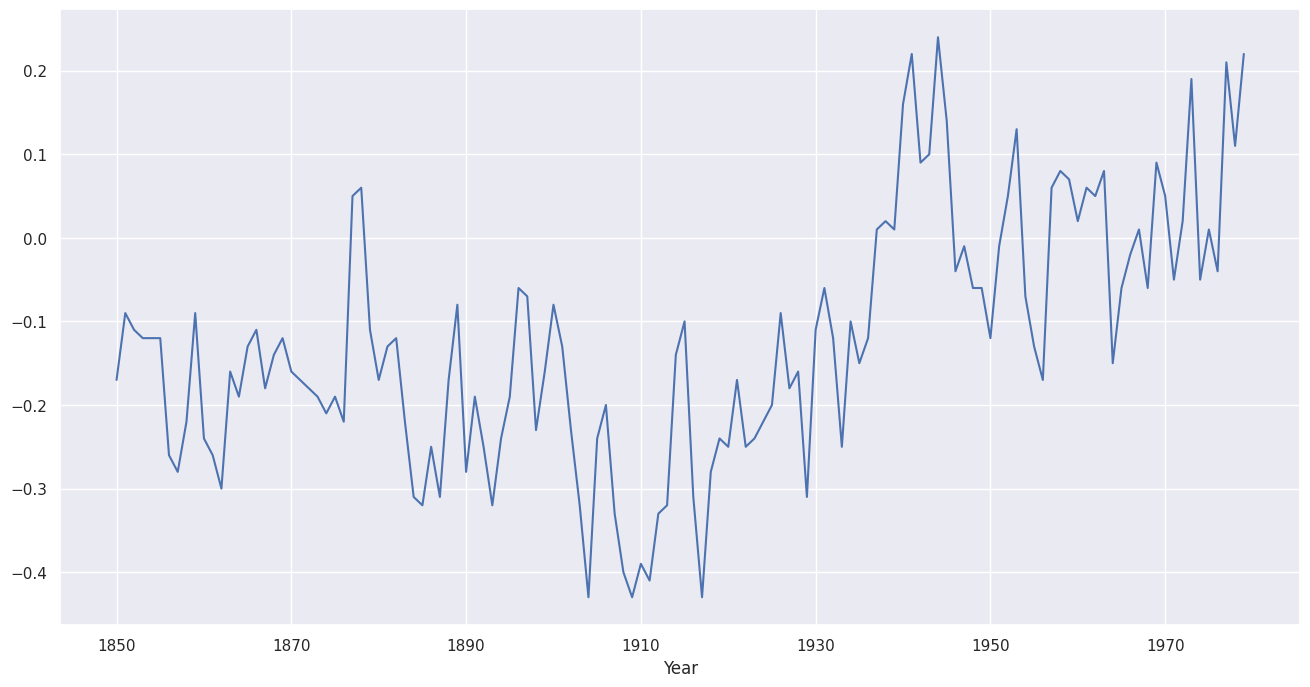

In [13]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [14]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [16]:
custom_model_request_dict = {
    'type': 'meta_wa',
    'score': ['smape', 'mape'],
    'param': {
        'base_models': [
            {'type': 'darts_autoarima'},
            {'type': 'darts_autotheta'},
            {'type': 'darts_autoets'},
            {'type': 'stats_autotheta'},
        ]
    }
}

In [17]:
custom_model_request = json.dumps(custom_model_request_dict)

Train API JSON Payload

In [18]:
api_json = {
    'data': train_data,
    # 'model': custom_model_request,  # TODO: custom_model_request_dict returns empty JSON output
}

Build URL

In [19]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [20]:
# URL to our SYBIL AWS service
protocol = url_dict["protocol"]
host = url_dict["host"]
port = url_dict["port"]
endpoint = "train"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

In [21]:
protocol, host, port

('http', 'localhost', 80)

Call endpoint, receive response JSON, write to output file

In [22]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: user 5.04 ms, sys: 687 µs, total: 5.73 ms
Wall time: 5.03 ms


In [23]:
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
train_json_out

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [ ]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [ ]:
test_data[:2]

Model from Train API

In [ ]:
model = train_json_out["model"]

Forecast API JSON Payload

In [ ]:
api_json = {
    'model': model,
    'predicts': test_data
}

Build URL (same as train except for the endpoint)

In [ ]:
endpoint = "forecast"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [ ]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

In [ ]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [ ]:
forecast_json_out

Combine forecast dates and output

In [ ]:
forecast_df = pd.DataFrame(forecast_json_out["data"], columns = [time_col, target_col])

In [ ]:
forecast_df.shape

In [ ]:
forecast_df.columns

In [ ]:
forecast_df.head()

In [ ]:
forecast_df.tail()

Plot train and forecast side-by-side

In [ ]:
train_df["color"] = "b"
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df["color"]);

In [ ]:
forecast_df["color"] = "r"
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df["color"]);

Combine train and test sets

In [ ]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.tail()

Plot combined train and test sets with the vertical black line as the cut-off

In [ ]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color=df["color"])
plt.axvline(x=len(train_df), color='black', label ='Train/Test set cut-off')
plt.show();